# Surface molecule numbers compendium
Counts of TCR, pMHC as a function of antigen pulse concentration, tumor antigens, etc. on each tumor and T cell line for which I have data. 

All calibrations (except the oldest ones) were done with Bangs Labs kits. 

Using the concatenated dataframe from Sooraj. Simply computing the geometric mean of each molecule on each cell type, and the CI on this mean. The model is based on cell averages. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit, lsq_linear
from scipy.stats import linregress
import os

# Local modules
import sys
if "../" not in sys.path:
    sys.path.insert(1, "../")
from utils.preprocess import geo_mean_apply

In [2]:
data_folder = "../data/surface_counts/"
do_save_stats = False

## Useful functions

In [3]:
def michaelis_menten(x, a, h):
    normx = (x / h)
    return a * normx / (1.0 + normx)

def loglog_michaelis_menten(logx, a, h):
    logh = np.log(h)
    return np.log(a * np.exp(logx - logh) / (1.0 + np.exp(logx - logh)))

def loglog_michaelis_background(logx, a, h, back):
    logh = np.log(h)
    # a is the real amplitude, there is a background on top, additive. 
    return np.log(a*np.exp(logx - logh) / (1.0 + np.exp(logx - logh)) + back)

def bootstrap_f_ci(x, f, a=0.05, reps=100, rel_size=0.8, rgen=None):
    # Generate reps bootstrap samples, compute f of each, compute 95 % CI of f
    # f could be geometric mean for instance. 
    if rgen is None:
        rgen = np.random.default_rng()
    boot_f_samples = []
    for i in range(reps):
        bootsamp = rgen.choice(x, size=int(rel_size*x.size), replace=True)
        boot_f_samples.append(f(bootsamp))
    # Confidence intervals
    boot_f_samples = np.asarray(boot_f_samples)
    ci_bounds = np.quantile(boot_f_samples, [a/2, 1.0-a/2])
    labels = ["CI "+str(round(x, 3)) for x in [a/2, 1.0-a/2]]
    return {labels[i]:ci_bounds[i] for i in range(2)}

def geo_mean(x):
    return np.exp(np.log(x).mean())

def stdev_of_log10(x):
    return np.std(np.log10(x), ddof=1)

def stats_from_single_cells(ser, by, seed=None, boot_kws={}):
    boot_kws.setdefault("a", 0.05)
    boot_kws.setdefault("reps", 1000)
    boot_kws.setdefault("rel_size", 0.8)
    ser_stats = (ser.groupby(by).aggregate(**{
                    "Mean": "mean", 
                    "Geometric mean": geo_mean,
                    "Percentile 2.5": lambda x: np.quantile(x, 0.025), 
                    "Percentile 97.5": lambda x: np.quantile(x, 0.975), 
                    "Median": "median", 
                    "Standard deviation": "std",
                    "Stdev log10": stdev_of_log10, 
                    "dof": "count"
                }))
    rgen = np.random.default_rng(seed)
    # CI on mean
    new_cols = ["Mean CI 0.025", "Mean CI 0.975"]
    ser_stats[new_cols] = (ser.groupby(by).apply(
                            bootstrap_f_ci, np.mean, 
                            **boot_kws, rgen=rgen).unstack(-1))
    # CI on geometric mean
    new_cols = ["Geometric mean CI 0.025", "Geometric mean CI 0.975"]
    ser_stats[new_cols] = (ser.groupby(by).apply(
                            bootstrap_f_ci, geo_mean, 
                            **boot_kws, rgen=rgen).unstack(-1))
    return ser_stats

## MHC loading vs pulse concentration (from RMA-S cells)
How do pulse concentrations relate to loaded pMHCs? The pulse vs pMHC calibration was done on B6 splenocytes, not on all tumor cells, for which we only know the total number of MHCs available for binding. Can we infer ligand numbers at all pulse concentrations for the latter?

Well, from a simple ligand-receptor binding model, where ligand=antigen and receptor=pMHC, the number of bound receptors $M$, as a function of ligand concentration $L$, obeys:

$$ \dot{M} = \kappa (M_{tot} - M) L - \lambda M $$

with steady-state 

$$ M = M_{tot} \frac{L}{L + K_D}  \quad \text{where } K_D = \lambda/\kappa $$

The $K_D$ is the point at which receptors start to saturate, and it depends only on the affinity (binding and unbinding rates) of the antigen-MHC pair, *not* on the total number of receptors. So, $K_D$ can be assumed constant across APC types (at least for SIINFEKL peptides); changing the total number of MHC on APCs simply scales $M$ proportionally, while the $L$ concentration saturating the $M_{tot}$ receptors does not change. So for instance, 1 $\mu$ M pulses will always saturate MHCs, no matter if the APC has $10^4$ or $10^6$ MHCs on its surface.   

In fact, we can fit $K_D$ on MFI data, then scale to absolute receptor numbers just using the total MHC count, available for tumor cells at least. 


### Final word on how to convert pulse concentration to pMHC number
In the end, all we need to store is the pulse-loading $K_D$, fitted once, and the total number of MHC available on each cell type (converted from MFI measurement). WE will do the latter later; here let's just infer the loading $K_D$ from the RMAs assays. 

### Fitting Michaelis-Menten relationship

For an actual fit, we need to fit the background as well, and to force the amplitude and background around the actual values we see. Otherwise, can't fit a MM function on data that starts at $10^3$! The right model to fit is MM + background. 

In [4]:
df_rmas = pd.read_hdf(data_folder + "combinedRMASDf_MFI.hdf", key="df")
# Convert concentrations to uM, more convenient to read. 
df_rmas = df_rmas.rename(lambda x: x*1e6, level="Concentration_M")
# Reorder levels to more convenient form
df_rmas = df_rmas.reorder_levels(["Experiment", "Replicate", "Peptide", "Concentration_M"])
df_rmas.index = df_rmas.index.set_names(["Experiment", "Replicate", "Peptide", "Concentration_uM"])
df_rmas

Time                                                   10.0
Experiment      Replicate Peptide Concentration_uM         
20200918-RMAS_2 1         N4      1.000000e+01      11472.0
                                  3.000000e+00      10882.0
                                  1.000000e+00       8985.0
                                  1.000000e-01       5987.0
                                  3.000000e-02       3679.0
...                                                     ...
20190912-RMAS_1 2         E1      5.000000e-05        606.0
                                  1.581139e-05        602.0
                                  5.000000e-06        585.0
                                  1.581139e-06        617.0
                                  5.000000e-07        605.0

[336 rows x 1 columns]

For every peptide, every replicate, fit Michaelis-Menten $R = R_0 L / (L + K_D)$, but fit in log-log scale: if $y=\log(R)$ and $x=\log(L)$, fit $y$ vs $x$ in the following relationship: $y = \log\left(\frac{R_0  e^x}{e^x + K_D} \right)$. 
So MM parameters describe relationship in linear scale, we just fitted them to minimize error on log-scale to ensure multiple orders of magnitude are well captured. This is a linear MM relationship plotted in log-log, not a MM function fitted on the log-log plot. 

In [5]:
def fit_ligand_receptor_mm(df):
    """ To be applied on the sub-dataframe corresponding to one dose-response. """
    x = np.log(df.index.get_level_values("Concentration_uM").values)
    y = df.values.flatten()
    pbounds = np.asarray([(0.7*np.amax(y), np.exp(x.min())/10.0, 0.5*np.amin(y)), 
               (2.0*np.amax(y), np.exp(x.max())*10, 1.5*np.amin(y))])
    y = np.log(y)
    l_conc_mm_params = curve_fit(loglog_michaelis_background, x, y, p0=np.mean(pbounds, axis=0), bounds=pbounds)[0]
    return l_conc_mm_params

In [6]:
all_params = []
gby = df_rmas.groupby(["Experiment", "Replicate", "Peptide"])
for lbl, gp in gby:
    fit_params = fit_ligand_receptor_mm(gp)
    all_params.append(fit_params)
all_params = pd.DataFrame(all_params, index=pd.MultiIndex.from_tuples(gby.groups, 
                names=["Experiment", "Replicate", "Peptide"]), 
                columns=["amplitude", "ec50", "background"])
all_params = all_params.reorder_levels(["Experiment", "Replicate", "Peptide"])
all_params

amplitude      ec50   background
Experiment      Replicate Peptide                                     
20190912-RMAS_1 1         A2       11104.788226  0.189277   632.169768
                          E1       10450.044133  0.195868   638.070769
                          G4       10340.249130  0.121867   710.956685
                          N4       10652.782783  0.138537   590.022529
                          Q4       11980.043717  0.118486   662.508374
                          T4       11605.997287  0.171166   647.945877
                          V4        9996.395913  0.042738   708.070767
                          Y3       11534.196427  0.110840   651.846146
                2         A2       11596.777933  0.148197   634.188133
                          E1        9868.428254  0.178231   624.161300
                          G4       10271.504619  0.112913   622.248166
                          N4       11298.894234  0.145632   596.340431
                          Q4       10783.812937  0.096549   631.036003
                          T4       11055.704730  0.172820   625.153587
                          V4        9638.537791  0.064546   647.743619
                          Y3       10978.620630  0.089165   633.717173
20200918-RMAS_2 1         A2        9974.207158  0.096240  1137.440755
                          E1        7054.287691  0.175365   971.717123
                          G4        6288.341354  0.103219   802.007001
                          N4        9329.919236  0.076745  1235.977898
                          Q4        7460.829423  0.078367   954.832677
                          T4        7203.931593  0.093736   912.536642
                          V4        6942.337130  0.066688   835.300948
                          Y3        9490.690871  0.041633  1037.897473

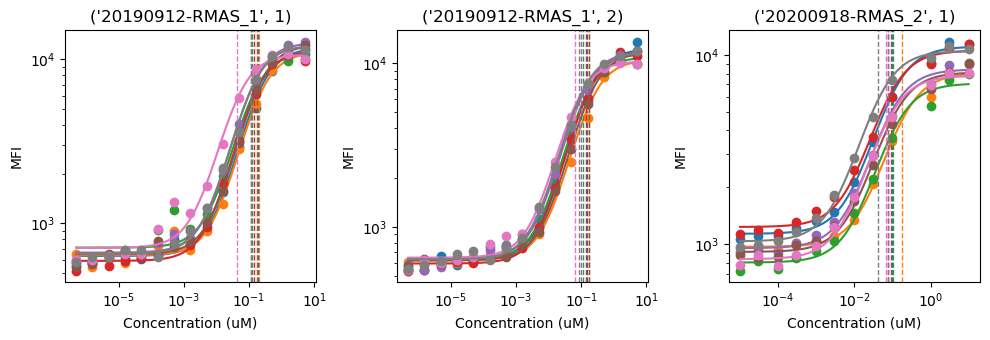

In [7]:
# Plot fits to make sure they are reasonable
plot_idx = all_params.index.droplevel(["Peptide"]).unique()
n_plots = len(plot_idx)
fig, axes = plt.subplots(1, n_plots)
fig.set_size_inches(10, 3.5)
axes = axes.flatten()
all_params = all_params.sort_index()
df_rmas = df_rmas.sort_index()
df_curves = {}
for i, k in enumerate(plot_idx):
    for pep in all_params.loc[k].index.unique():
        x = df_rmas.loc[k+(pep,)].index.get_level_values("Concentration_uM").values
        xrange = np.geomspace(x.min(), x.max(), 101)
        y = df_rmas.loc[k+(pep,)].values.flatten()
        pms = all_params.loc[k+(pep,)]
        ymod = np.exp(loglog_michaelis_background(np.log(xrange), *pms))
        xy_df = pd.DataFrame(np.stack([xrange, ymod], axis=1), 
                             index=pd.RangeIndex(101, name="Point"), 
                             columns=["x", "y"])
        df_curves[tuple(k) + (pep,)] = xy_df.copy()
        li, = axes[i].plot(xrange, ymod, label=pep)
        c = li.get_color()
        axes[i].plot(x, y, color=c, mfc=c, mec=c, marker="o", ms=6, ls="none")
        axes[i].axvline(pms.iat[1], ls="--", lw=1.0, color=c)
    axes[i].set_title(k)
    axes[i].set(xlabel="Concentration (uM)", ylabel="MFI", yscale="log", xscale="log")

df_curves = pd.concat(df_curves, names=all_params.index.names)
df_curves

fig.tight_layout()
plt.show()
plt.close()

In [8]:
#@title Statistics of loading EC50s
randomgen = np.random.default_rng(0x339788df8e03ab6f23168dec3dd313f3)
booted_params = np.log(all_params.T.copy())
booted_params = booted_params.apply(bootstrap_f_ci, axis=1, raw=False, args=(np.mean,), 
                        a=0.05, reps=1000, rel_size=0.8, rgen=randomgen, result_type="expand")
# Add mean
booted_params = np.exp(booted_params)
booted_params["Geometric mean"] = all_params.T.apply(geo_mean, axis=1)

# We only need the K_D; amplitude and background are relative to specific MFI here
# And will be replaced by the number of MHC on each APC type. 
mhc_pulse_kd = booted_params.loc["ec50"].copy()
mhc_pulse_kd.name = "K_D (uM)"

# Add 95 % CI of the distribution (not just CI of mean)
booted_lower_ci = np.log(all_params.T).apply(bootstrap_f_ci, axis=1, raw=False, 
                                             args=(lambda x: np.quantile(x, 0.025),), 
                        a=0.05, reps=1000, rel_size=0.8, rgen=randomgen, result_type="expand")
booted_upper_ci = np.log(all_params.T).apply(bootstrap_f_ci, axis=1, raw=False, 
                                             args=(lambda x: np.quantile(x, 0.975),), 
                        a=0.05, reps=1000, rel_size=0.8, rgen=randomgen, result_type="expand")
mhc_pulse_kd.loc["Quantile 0.025"] = np.exp(booted_lower_ci.loc["ec50"].mean())
mhc_pulse_kd.loc["Quantile 0.975"] = np.exp(booted_upper_ci.loc["ec50"].mean())
mhc_pulse_kd.loc["dof"] = all_params["ec50"].count()
mhc_pulse_kd  # in uM

CI 0.025           0.090108
CI 0.975           0.128559
Geometric mean     0.108340
Quantile 0.025     0.056792
Quantile 0.975     0.181460
dof               24.000000
Name: K_D (uM), dtype: float64

## All surface molecule numbers
Includes:
- MHC numbers (to combine with fraction of loaded MHC at a given pulse concentration)
- CAR antigens numbers
- TCR numbers
- CAR numbers

In [9]:
full_file = "completeMoleculeNumberDf.hdf"
df = pd.read_hdf(data_folder + full_file)
df

Molecules (#)
Cell      Marker Event               
OT1_Blast TCR    1       1.506025e+05
                 2       1.901796e+05
                 3       1.203154e+05
                 4       1.476964e+05
                 5       7.959540e+04
...                               ...
BEAS2B    MHC    5470    3.021412e+06
                 5471    3.021412e+06
                 5472    3.021412e+06
                 5473    3.021412e+06
                 5474    3.021412e+06

[538622 rows x 1 columns]

In [10]:
df_surface_numbers_stats = stats_from_single_cells(df["Molecules (#)"], by=["Cell", "Marker"], 
                                    seed=0xfdcef4d3def776989b198568b5886be6)
df_surface_numbers_stats

Mean  Geometric mean  Percentile 2.5  \
Cell        Marker                                                 
B16         CD19    9.532371e+05    7.878867e+05    1.833182e+05   
            MHC     1.468376e+03    4.842766e+02    1.802939e+02   
B6          CD19    4.823482e+04    8.005932e+03    1.802939e+02   
            MHC     6.260005e+04    5.271600e+04    1.704379e+04   
BEAS2B      Her2    1.932132e+04    1.705127e+04    5.415144e+03   
            MHC     3.015071e+06    3.007904e+06    3.021412e+06   
E2aPBX_19KO CD19    1.671748e+03    3.802909e+02    1.802939e+02   
            MHC     5.522729e+04    4.477462e+04    8.630137e+03   
E2aPBX_WT   CD19    1.424490e+05    1.065101e+05    1.351554e+04   
            MHC     7.113034e+04    5.797990e+04    1.164482e+04   
Nalm6_19KO  CD19    9.881800e+02    4.644495e+02    1.515185e+02   
            MHC     6.817233e+05    6.234836e+05    2.618637e+05   
Nalm6_19hi  CD19    5.035110e+05    4.622249e+05    1.707399e+05   
            MHC     9.156218e+05    8.138728e+05    2.802708e+05   
Nalm6_19int CD19    4.386891e+04    3.149995e+04    3.946869e+03   
            MHC     7.146041e+05    5.905154e+05    1.446776e+05   
Nalm6_19low CD19    7.931304e+03    4.389348e+03    1.515185e+02   
            MHC     1.041451e+06    8.254830e+05    8.040834e+04   
OT1_Blast   CAR     1.467484e+03    4.161231e+02    1.932185e+02   
            TCR     1.635252e+05    1.518833e+05    6.590905e+04   
OT1_CAR     CAR     1.290746e+06    9.811849e+05    1.311322e+05   
            TCR     1.398369e+05    1.217933e+05    3.018409e+04   
OT1_Naive   TCR     1.078227e+05    9.991064e+04    2.915776e+04   
PC9         Her2    3.664064e+04    3.329423e+04    1.290866e+04   
            MHC     8.737303e+05    7.377525e+05    1.762071e+05   

                    Percentile 97.5        Median  Standard deviation  \
Cell        Marker                                                      
B16         CD19       2.521373e+06  8.077539e+05       579171.029350   
            MHC        8.847813e+03  1.802939e+02         2635.708853   
B6          CD19       1.191934e+05  2.628082e+04       220152.089640   
            MHC        1.800740e+05  5.224399e+04        44603.683336   
BEAS2B      Her2       4.199202e+04  1.768514e+04         9454.917614   
            MHC        3.021412e+06  3.021412e+06       101115.467830   
E2aPBX_19KO CD19       5.539173e+03  1.802939e+02        36231.899957   
            MHC        1.398611e+05  4.852502e+04        34217.266245   
E2aPBX_WT   CD19       3.652103e+05  1.206604e+05       160009.079567   
            MHC        1.768652e+05  6.349488e+04        42981.670467   
Nalm6_19KO  CD19       3.399009e+03  4.256573e+02        10086.695105   
            MHC        1.357161e+06  6.323414e+05       284007.900507   
Nalm6_19hi  CD19       9.491584e+05  4.822472e+05       197037.240338   
            MHC        1.959104e+06  8.451934e+05       430044.379758   
Nalm6_19int CD19       1.178612e+05  3.563178e+04        56581.460092   
            MHC        1.744689e+06  6.323414e+05       417129.300840   
Nalm6_19low CD19       2.999965e+04  5.483816e+03         8728.748267   
            MHC        2.422883e+06  9.676724e+05       582480.225228   
OT1_Blast   CAR        4.157355e+03  2.195097e+02        20263.003799   
            TCR        3.206484e+05  1.550672e+05        63724.896723   
OT1_CAR     CAR        3.431407e+06  1.140168e+06       850008.155760   
            TCR        3.112514e+05  1.285903e+05        70774.098629   
OT1_Naive   TCR        1.762415e+05  1.093637e+05        41140.034784   
PC9         Her2       7.255239e+04  3.446743e+04        16344.865229   
            MHC        2.089305e+06  7.909687e+05       493585.009025   

                    Stdev log10     dof  Mean CI 0.025  Mean CI 0.975  \
Cell        Marker                                                      
B16         CD19       0.286339    5375   9.361632e+05   9.695231e+05   


In [11]:
# Check that the numbers agree well with what I had before
df_surface_numbers_stats["Geometric mean"].loc[(["BEAS2B", "PC9"], "MHC")]

Cell    Marker
BEAS2B  MHC       3.007904e+06
PC9     MHC       7.377525e+05
Name: Geometric mean, dtype: float64

## Save results to one hdf file with both dataframes

In [12]:
filename = data_folder + "surface_molecule_summary_stats.h5"
useful_frames = {
    "mhc_pulse_kd": mhc_pulse_kd, 
    "surface_numbers_stats": df_surface_numbers_stats, 
}
if do_save_stats:
    for nm, df in useful_frames.items():
        df.to_hdf(filename, key=nm)

In [13]:
# Export to LateX for manuscript: this is now done by the dedicated Python script
# secondary_scripts/mcmc_ci_to_latex.py. 
# secondary_scripts/print_dataset_sizes.py also prints 
# important information for the Supplementary Tables. 

In [14]:
# Also export MHC pulse KD to a small tex string to be inserted
# Round to significant figure
pulse_kd_tex = np.log10(1e3*mhc_pulse_kd[["Geometric mean", "Quantile 0.975", "Quantile 0.025"]])
pulse_kd_tex.index = pd.Index(["m", "up", "lo"])
# Find last significant digit
decimal_place = min(abs(pulse_kd_tex["up"] - pulse_kd_tex["m"]), 
                      abs(pulse_kd_tex["m"] - pulse_kd_tex["lo"]))
decimal_place = abs(np.floor(np.log10(decimal_place)).astype(int))



kd_load_str = (r"$\log_{10} (K_{\mathrm{D,\, load}}/1\mathrm{nM}) = " 
            + str(round(pulse_kd_tex["m"], decimal_place))
            + r"^{+" 
            + str(round(pulse_kd_tex["up"] - pulse_kd_tex["m"], decimal_place)) 
            + r"}_{-"
            + str(round(pulse_kd_tex["m"] - pulse_kd_tex["lo"], decimal_place))
            + r"}$"
)
print(kd_load_str)
if do_save_stats:
    with open("../results/for_plots/mhc_pulse_kd_string.tex", "w") as f:
        f.write(kd_load_str)

$\log_{10} (K_{\mathrm{D,\, load}}/1\mathrm{nM}) = 2.0^{+0.2}_{-0.3}$
